In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
import numpy as np

from ipynb.fs.defs.functions import prep_data, train

# Setup rng
torch.manual_seed(42)
np.random.seed(42)

In [2]:
# Check cuda is available and if so, set DEVICE to use gpu device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cuda


## Data Preparation

In [3]:
data = pd.read_csv("data/unzipped/training_solutions_rev1.csv")

In [5]:
train_dataset, test_dataset, val_dataset = prep_data(data)

## Model Definition

In [15]:
# Define a torch model
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)

        # Max pooling
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Dropout
        self.dropout = nn.Dropout(p=0.5)

        # Batch normalization
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)

        # Fully connected layers
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(in_features=128 * 8 * 8, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=64)
        self.fc3 = nn.Linear(in_features=64, out_features=37)

        # Activation functions
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        # Convolutional layers
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = torch.nn.functional.normalize(x, p=2, dim=1, eps=1e-12)
        x = self.dropout(x)
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = torch.nn.functional.normalize(x, p=2, dim=1, eps=1e-12)
        x = self.dropout(x)
        x = self.pool(self.relu(self.bn3(self.conv3(x))))
        x = torch.nn.functional.normalize(x, p=2, dim=1, eps=1e-12)
        x = self.dropout(x)

        # Fully connected layers
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.softmax(self.fc3(x))

        return x

## Hyperparameter Tuning

In [16]:
# Save path
save_path = "models/parametric/"

# Parameters
EPOCHS = 200
BATCH_SIZE = [16, 32, 64, 128, 256]
LR = [0.01, 0.001, 0.0001]
GAMMA = [0.9, 0.95, 0.99]

In [17]:
# Create a loss function
criterion = nn.CrossEntropyLoss()

In [19]:
# Train the model
train_losses, test_losses = [], []
for batch_size in BATCH_SIZE:
    for lr in LR:
        for gamma in GAMMA:
            print(f"Training model with batch size {batch_size}, lr {lr}, gamma {gamma}")
            model = Model()
            model.to(DEVICE)

            train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
            test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

            optimizer = torch.optim.Adam(model.parameters(), lr=lr)
            scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)

            train_loss, test_loss = train(model, EPOCHS, train_loader, test_loader, optimizer, scheduler, criterion)

            # Plot losses
            plt.plot(range(1, EPOCHS + 1), train_loss, label="Train loss")
            plt.plot(range(1, EPOCHS + 1), test_loss, label="Test loss")
            plt.xlabel("Epoch")
            plt.ylabel("Loss")
            plt.legend()
            plt.show()

            # Save the model
            model_name = f"{datetime.now().strftime('%y%m%d%H%M%S')}_model_E{EPOCHS}_B{batch_size}_LR{lr}_GAMMA{gamma}_TRAIN{train_loss[-1]:.4f}_TEST{test_loss[-1]:.4f}.pth"
            torch.save(model.state_dict(), save_path + model_name)
            print(f"Model saved as {model_name}")

            train_losses.append(train_loss)
            test_losses.append(test_loss)

Training model with batch size 16, lr 0.01, gamma 0.9
11/18 11:37:17 Train Epoch:    1 [49262/49262 (100%)]	Train Loss: 17.696320	Test Loss: 17.727423


KeyboardInterrupt: 

In [ ]:
# Plot losses
fig = plt.figure(figsize=(10, 6))
m = -1
for i in range(len(BATCH_SIZE)):
    for j in range(len(LR)):
        for k in range(len(GAMMA)):
            m += 1
            plt.plot(
                range(1, EPOCHS + 1),
                train_losses[m],
                label=f"Batch size {BATCH_SIZE[i]}, lr {LR[j]}, gamma {GAMMA[k]}",
            )

# Adjust y-axis limits
plt.ylim(0.042, 0.05)

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(bbox_to_anchor=(1.45, 1), loc="upper right", borderaxespad=0)
plt.show()


In [ ]:
# Plot losses
fig = plt.figure(figsize=(10, 6))
m = -1
for i in range(len(BATCH_SIZE)):
    for j in range(len(LR)):
        for k in range(len(GAMMA)):
            m += 1
            plt.plot(
                range(1, EPOCHS + 1),
                test_losses[m],
                label=f"Batch size {BATCH_SIZE[i]}, lr {LR[j]}, gamma {GAMMA[k]}",
            )

# Adjust y-axis limits
plt.ylim(0.042, 0.05)

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(bbox_to_anchor=(1.45, 1), loc="upper right", borderaxespad=0)
plt.show()

Train losses

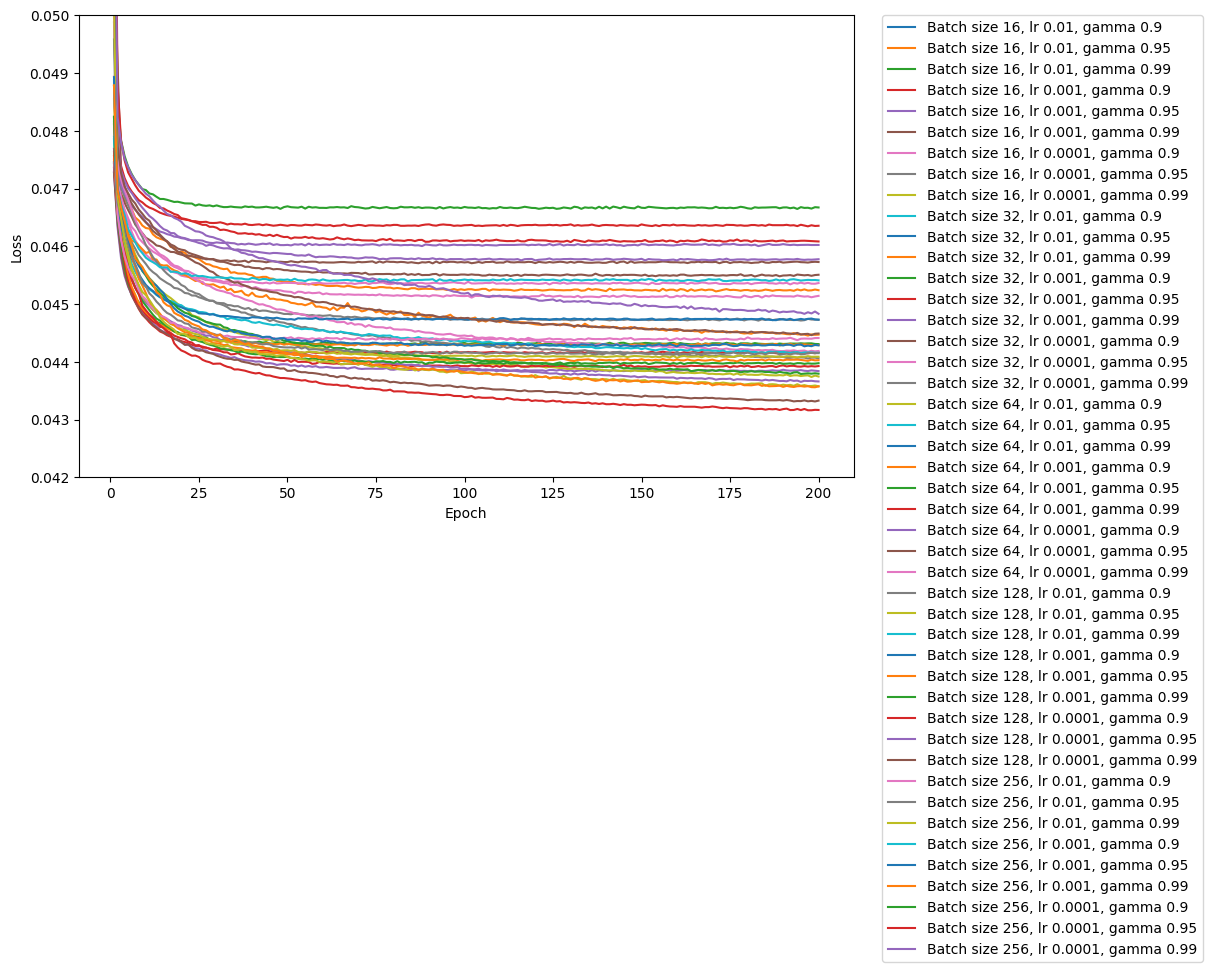

Test Losses

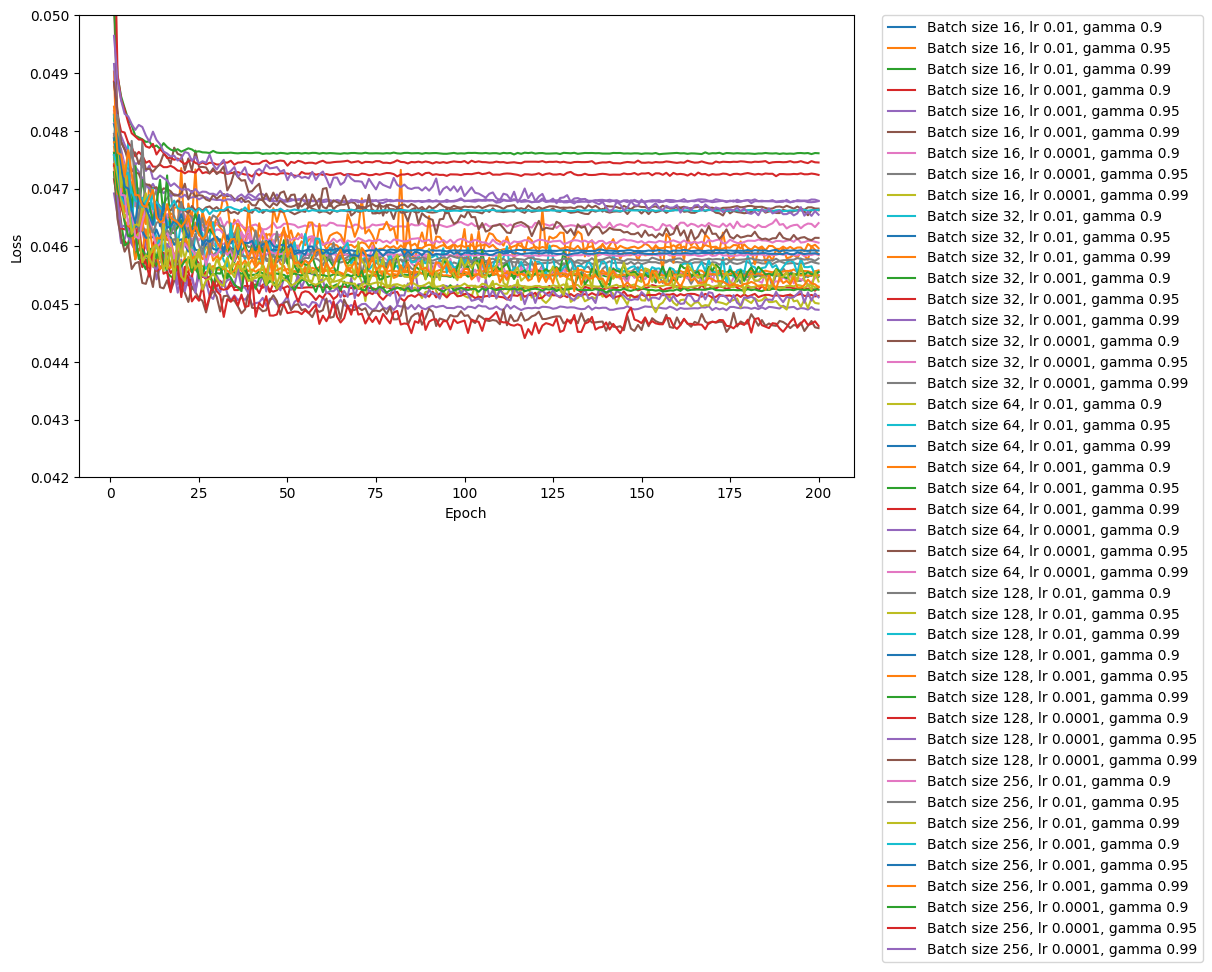